<a href="https://colab.research.google.com/github/musa321/-Introduction-to-Data-Science-with-Python/blob/main/notebooks/04a-graph-networks-completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Graph Networks

In this notebook, we will construct a convolutional graph neural network and use it predict the elastic properties of materials. We implement the [CGCNN model](https://github.com/txie-93/cgcnn) from scratch using pytorch.

The notebook is split into three sections:
1. Data loading and analysis
2. Model construction
3. Model training and evaluation

The notebook depends on:
- torch
- ase
- torch-scatter

Alex Ganose, *Imperial College London* (2023)

## Dependencies

First, install the required dependencies.

In [6]:
! pip install torch_scatter
! pip install ase


  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3662075 sha256=6b9b15c3bf9084759a70816281273eacec8d425683d78ce45eb8506a6ce698cc
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch_scatter


In [10]:
!wget https://raw.githubusercontent.com/mdi-group/iisc-ml-school/refs/heads/main/notebooks/utils.py
!wget https://raw.githubusercontent.com/mdi-group/iisc-ml-school/refs/heads/main/notebooks/bulk-modulus-dataset.jsonhttps://raw.githubusercontent.com/mdi-group/iisc-ml-school/refs/heads/main/notebooks/utils.py

--2025-01-07 11:42:32--  https://raw.githubusercontent.com/mdi-group/iisc-ml-school/refs/heads/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6470 (6.3K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   6.32K  --.-KB/s    in 0s      

2025-01-07 11:42:32 (90.2 MB/s) - ‘utils.py.2’ saved [6470/6470]

--2025-01-07 11:42:32--  https://raw.githubusercontent.com/mdi-group/iisc-ml-school/refs/heads/main/notebooks/bulk-modulus-dataset.jsonhttps://raw.githubusercontent.com/mdi-group/iisc-ml-school/refs/heads/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Now, import all the functions and modules necessary to run the notebook.

In [11]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch_scatter
from torch.utils.data import DataLoader, random_split

from utils import MaterialsDataset, collate_fn, plot_sample

## Ensure reproducibility

We need to set a random seed to ensure consistent results.

In [12]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load the dataset

We will be using the [matbench](http://matbench.materialsproject.org) `log_gvrh` dataset which contains 10,987 VRH-average shear moduli calculated using DFT.
The dataset has been preprocessed by taking the base 10 logarithm as the data spans several order of magnitude.

The original dataset can be obtained using the [`matminer`](https://hackingmaterials.lbl.gov/matminer/) package, however for this notebook, we have included a version of the dataset with some adjustments to the data structures.

In [13]:
dataset = MaterialsDataset(
    "bulk-modulus-dataset.json",
    cutoff=4,  # cutoff radius for finding neighbours
    num_gaussians=40,  # number of gaussians in edge embedding
)

## Take a look at the data

It's always a good idea to look a bit at the data. First, let's plot a histogram of the target values.

[Text(0.5, 0, 'log10(G$_\\mathrm{VRH}$)'), Text(0, 0.5, 'Number of examples')]

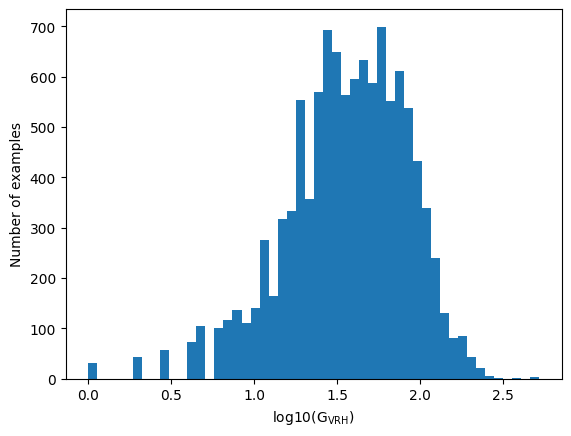

In [14]:
values = [x.target[0] for x in dataset]

fig, ax = plt.subplots()
ax.hist(values, bins=50)
ax.set(xlabel="log10(G$_\mathrm{VRH}$)", ylabel="Number of examples")

Now let's look at the structure of the data. Each sample has the following information:

- `node_feat`: The node features as a ($N$, num_node_features) tensor.
- `edge_feat`: The edge features as a ($M$, num_edge_features) tensor.
- `edge_src` : The index of the central node for each edge.
- `edge_dst` : The index of the destination node for each edge.
- `target` : The target property to learn.
- `atoms`: An ase atoms object, representing the structure.

Here, $N$ and $M$ are the number of nodes and edges in the structure, respectively.

Let's have a look at the node features for the first material in the dataset.

In [15]:
sample = dataset[0]
sample.node_feat.shape

torch.Size([5, 119])

This tells us there are 5 atoms in the structure, and each node has 119 features. The initial node features are just a one-hot encoding of the atom type. If we look at the first atom, we can see it has a `1` at the 19th index in the tensor and zeros elsewhere, indicating that this is the 20th element in the periodic table, i.e., calcium.

In [16]:
print(sample.node_feat[0])
print(sample.node_feat[0][19])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(1.)


Let's also look at the edge features.

In [17]:
sample.edge_feat.shape

torch.Size([58, 40])

Here we can see there are 58 edges in the structure. On average, that works out to ~10 edges per atom. There are 40 features per edge. Let's have a look at the features for the first edge in the material.

In [18]:
sample.edge_feat[0]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7147e-39,
        1.5296e-31, 1.1663e-24, 1.2036e-18, 1.6810e-13, 3.1773e-09, 8.1274e-06,
        2.8136e-03, 1.3182e-01, 8.3582e-01, 7.1722e-01, 8.3293e-02, 1.3091e-03,
        2.7845e-06, 8.0156e-10, 3.1227e-14, 1.6464e-19])

The edge embedding is the bond length projected onto a basis of 40 equally spaced gaussians. To understand this visually, consider the following plot where was have drawn a schematic of the gaussian basis functions. Each coloured line corresponds to one basis function. In this case we are only plotting 10 basis functions for clarity.

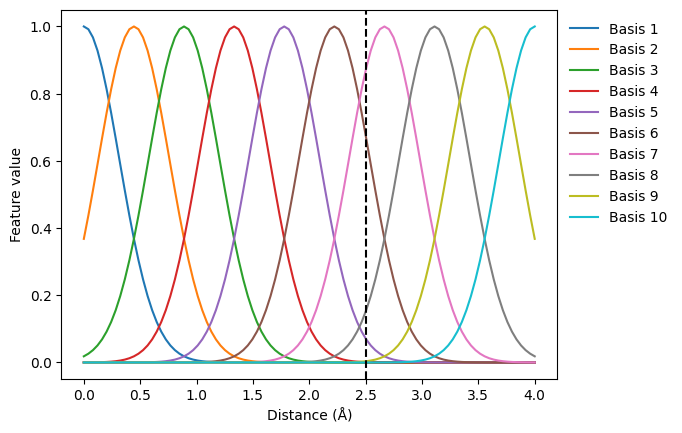

In [19]:
fig, ax = plt.subplots()
dists = np.linspace(0, 4, 100)
centres = np.linspace(0, 4, 10)
edge_feat = np.exp(-((dists[:, None] - centres) ** 2) / (centres[1] - centres[0]) ** 2)
ax.plot(dists, edge_feat, label=[f"Basis {i+1}" for i in range(10)])
ax.axvline(2.5, ls="--", color="k")
ax.set(xlabel="Distance (Å)", ylabel="Feature value")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)

To understand the embedding, consider a bond length of 2.5 Å shown by the black dotted line. For each basis function, the value of the function at 2.5 Å is used to form the embedding. IN this case, the first 3 basis functions have a value very close to zero at 2.5 Å, whereas basis functions 6 and 7 will have high values.

In this example, the embedding would be:

In [20]:
edge_feat = np.exp(-((2.5 - centres) ** 2) / (centres[1] - centres[0]) ** 2).round(3)
edge_feat

array([0.   , 0.   , 0.   , 0.001, 0.071, 0.677, 0.869, 0.151, 0.004,
       0.   ])

The final piece of information necessary for convolutional graph networks are the indices of the central and destination nodes for each bond. Let's look at the source indices for our sample structure.

In [21]:
sample.edge_src

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

The numbers correspond to the index of the atoms in the structure. In our structure there are 5 atoms, so the indices only go up to 4 (all python arrays are zero-indexed).
The first 15 numbers are all zero, indicating that the first atom in the structure has 15 bonds.

Now let's look at the destination indices.

In [22]:
sample.edge_dst

tensor([2, 4, 1, 2, 4, 3, 2, 3, 1, 1, 4, 3, 3, 2, 1, 4, 4, 3, 4, 3, 2, 0, 0, 0,
        0, 4, 0, 4, 0, 0, 3, 3, 0, 1, 0, 0, 4, 4, 1, 0, 4, 2, 4, 2, 1, 0, 2, 3,
        3, 2, 1, 0, 0, 0, 3, 0, 1, 3])

Concentrating on the first 15 numbers (corresponding to atoms bonded to the first atom in the structure) you can see that there can be more than one bond to the same destination atom. The reason for this is periodic boundary conditions. Some of these bonds will be to atoms in adjacent unit cells. For that reason, their bond lengths and corresponding edge embeddings will all be different.

You can think of the `edge_src` and the `edge_dst` as the node $i$ and $j$ indices from the lecture slides.

We can visualise the structure and corresponding graph using the builtin helper function. Note, the plot only shows one edge per pair of atoms.

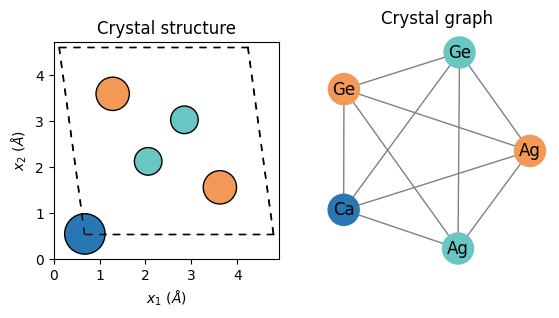

In [23]:
plot_sample(sample)

## Split the data for train, test, and validation

Now we split the dataset into the training, testing, and validation sets. Recall that the validation set is different from the test set.
The validation set can be used to select hyperparameters, so is strictly part of the model selection process.

We use 80% of the data for training, 10% for validation, and 10% for testing.

In [24]:
train_set, valid_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(valid_set)}')
print(f'Number of testing examples: {len(test_set)}')

Number of training examples: 8790
Number of validation examples: 1099
Number of testing examples: 1098


## Set up the batches

We can also set up the mini-batches for training. Here, we use a custom "collate function" that will automatically handle grouping multiple graphs into a batch.

In [25]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True,
)

valid_loader = DataLoader(
    valid_set, batch_size=BATCH_SIZE, collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, collate_fn=collate_fn,
)

## Explore the batch data format

Before starting to construct the neural network architecture, it is worth spending a little time getting familiar with the format of the batched data.

Each batch has the following information:

- `node_feat`: The node features as a ($N$, n_node_feats) tensor.
- `edge_feat`: The edge features as a ($M$, n_edge_feats) tensor.
- `edge_src` : The index of the central node for each edge.
- `edge_dst` : The index of the destination node for each edge.
- `target` : The target property to learn, as a ($G$, 1) tensor.
- `batch` : The graph to which each node belongs, as a ($N$, ) Tensor.

Here $N$ and $M$ are the total number of atoms *in the batch*. $G$ is the total number of graphs (structures) in the batch.

Let's have a look at the node features for the first batch of the test set.

In [26]:
batch = next(iter(test_loader))
batch.node_feat.shape

torch.Size([302, 119])

Notice how now there are many more nodes (518 of them). The number of node features (i.e., the one-hot enconding of atom types) has remained the same.

The number of edges in the batch has also increased significantly.

In [27]:
batch.edge_feat.shape

torch.Size([5778, 40])

Because we need to handle multiple graphs simultaneously, the `batch.batch` attribute is essential to know which graph each atom belongs to.
Let's look at the first 100 values in this array.

In [28]:
batch.batch[:100]

tensor([ 0,  0,  0,  0,  0,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13,
        13, 13, 13, 13, 13, 14, 14, 14, 14, 14])

This tells us that the first five nodes in the `batch.node_feat` array correspond to the first structure, while the next two nodes belong to the second structure, etc.

## Crystal Graph Convolutional Neural Networks – Convolution

The first step in building the model is defining a graph convolution.

In the CGCNN model, we need to compute the following steps:

$$
\mathbf{m}_i^{(t)} = \mathbf{v}_i^{(t)} \bigoplus \mathbf{v}_j^{(t)} \bigoplus \mathbf{e}_{ij}^{(t)}
$$

where $i$ and $j$ are the indices of the central and neighbouring atoms, $\mathbf{v}^{(t)}$ and $\mathbf{e}^{(t)}$ are the node and edge embeddings for convolution $t$. The update function is performed as:

$$
\mathbf{z}_i^{(t)} = \mathbf{v}_i^{(t)} + \sum_{j \in \mathcal{N}(i)}
 \sigma \left ( \mathbf{W}_f^{(t)} \mathbf{m}_i^{(t)} + \mathbf{b}_f^{(t)} \right )
 \bigodot g \left ( \mathbf{W}_s^{(t)} \mathbf{m}_i^{(t)} + \mathbf{b}_s^{(t)} \right )
$$

$$
\mathbf{v}_i^{(t+1)} = g(\mathbf{z}_i^{(t)})
$$

where $\sigma$ and g are the sigmoid and softplus activation functions, and $\mathbf{W}$ and $\mathbf{b}$ are the weights and biases.

## Convolution implementation

As discussed in the previous lesson, in pytorch we build networks as a class. Below, we have implemented the convolution layer from CGCNN.
The steps required to build a network can be summarised as:
- Declare the class - it should be a subclass of the `nn.Module` class from `pytorch`
- Define what inputs it takes upon declaration - in this case `node_feat_dim` and `edge_feat_dim`
- `super` makes sure it inherits attributes from nn.Module
- We then define the different types of layers that we will use – in this case we have a linear layer and two batch normalisation layers.
- Then we define a method `forward` which is what gets called when data is passed through the network, this basically moves the data x through the layers



In [29]:
class GraphConvolution(nn.Module):

    def __init__(self, node_feat_dim, edge_feat_dim):
        """
        Convolutional layer for graphs.

        Parameters
        ----------
        node_feat_dim : int
          Number of node features.
        edge_feat_dim : int
          Number of edge features.
        """
        super().__init__()

        # linear layer used for the gated MLP
        self.lin1 = nn.Linear(
            2 * node_feat_dim + edge_feat_dim,
            2 * node_feat_dim,
        )

        # normalisation layers
        self.bn1 = nn.BatchNorm1d(2 * node_feat_dim)
        self.bn2 = nn.BatchNorm1d(node_feat_dim)

    def forward(self, node_feat, edge_feat, edge_src, edge_dst):
        """Perform the convolution.

        Parameters
        ----------
        node_feat : Tensor
            The node features.
        edge_feat : Tensor
            The edge features
        edge_src : Tensor
            The indices of the central nodes for the edges.
        edge_dst : Tensor
            The indices of the desintation nodes for the edges.
        """
        # concatenate node and edge features
        m = torch.cat([node_feat[edge_src], node_feat[edge_dst], edge_feat], dim=1)

        # gated MLP
        z = self.lin1(m)
        z = self.bn1(z)
        z1, z2 = z.chunk(2, dim=1)
        z1 = nn.Sigmoid()(z1)
        z2 = nn.Softplus()(z2)
        z = z1 * z2

        # pool features
        z = torch_scatter.scatter_add(z, edge_src, out=torch.zeros_like(node_feat), dim=0)

        # pass through normalisation layer
        return nn.Softplus()(self.bn2(z) + node_feat)

Have a look at the `forward` method of the convolution and see if you can understand the components and their relation to the formulas described above. Note that the implementation includes two normalisation layers `bn1` and `bn2` that are omitted from the formulas for clarity.

## Full graph network architecture

Now we have the convolution, we can construct the full CGCNN model.

The additional components of the CGCNN architecture are as follows:
- An MLP that transforms the one-hot encoded node features to the node embedding. The dimensionality of the node embedding is controlled by `node_hidden_dim`.
- The pooling of node features to obtain the crystal features $\mathbf{u}_c$, calculated as:

$$
\mathbf{u}_c = \sum_{i \in \mathcal{G}} \frac{\mathbf{v}_i^{(T)}}{|\mathcal{G}|}
$$
- An MLP that takes $\mathbf{u}_c$ and outputs the target property. In CGCNN this consists of a fully-connected layer with soft-plus activation, followed by a fully-connected layer with no-activation function.

Below we give an implementation of the CGCNN model. The number of convolutions can be controlled using the `num_graph_conv_layers` parameter.


In [30]:
class CGCNN(nn.Module):
    def __init__(
        self,
        node_feat_dim,
        edge_feat_dim,
        node_hidden_dim=64,
        num_graph_conv_layers=3,
        fc_feat_dim=128
    ):
        """
        Crystal Graph Convolutional Neural Network

        Parameters
        ----------
        node_feat_dim : int
          Number of initial node features from one-hot encoding.
        edge_feat_dim : int
          Number of bond features.
        node_hidden_dim : int
          The number of features in the node embedding.
        num_graph_conv_layers: int
          Number of convolutional layers.
        fc_feat_dim: int
          Number of hidden features after pooling.
        """
        super().__init__()

        # dense layer to transform one-hot encoded node features to embedding
        self.embedding = nn.Linear(node_feat_dim, node_hidden_dim)

        # set up the convolutions
        convs = []
        for _ in range(num_graph_conv_layers):
            convs.append(GraphConvolution(node_feat_dim=node_hidden_dim, edge_feat_dim=edge_feat_dim))
        self.convs = nn.ModuleList(convs)

        # dense layer to turn final node embeddings to the crystal features
        self.conv_to_fc = nn.Sequential(
           nn.Linear(node_hidden_dim, fc_feat_dim), nn.Softplus()
        )

        # dense layer to get the final target value
        self.fc_out = nn.Linear(fc_feat_dim, 1)

    def forward(self, batch):
        """
        Predict the target property given a batch of data.

        Parameters
        ----------
        batch : Batch
            The data to pass through the network.
        """
        # get initial node embedding
        node_feat = self.embedding(batch.node_feat)

        # apply convolutions
        for conv_func in self.convs:
            node_feat = conv_func(node_feat, batch.edge_feat, batch.edge_src, batch.edge_dst)

        # pool node vectors
        crys_feat = torch_scatter.scatter_mean(node_feat, batch.batch, dim=0)

        # pass pooled vector through FC layer with activation
        crys_feat = self.conv_to_fc(crys_feat)

        # pass crystal features through final fully-connected layer
        return self.fc_out(crys_feat)

Look at the `forward` method and see if you can understand the components and their relation to the formulas given above.

We can now use the `CGCNN` class to build the full network.

In [31]:
NUM_NODE_FEATURES = sample.node_feat.size()[1]
NUM_EDGE_FEATURES = sample.edge_feat.size()[1]

NUM_CONVOLUTIONS = 3

model = CGCNN(
    NUM_NODE_FEATURES,
    NUM_EDGE_FEATURES,
    num_graph_conv_layers=NUM_CONVOLUTIONS
)

##  Training the Model

Next, we'll define our optimizer. This is the algorithm we will use to update the parameters of our model with respect to the loss calculated on the data. We aren't going to go into too much detail on how neural networks are trained (see [this](http://neuralnetworksanddeeplearning.com/) article if you want to know how) but the gist is:
- pass a batch of data through your model
- calculate the loss of your batch by comparing your model's predictions against the target value
- calculate the gradient of each of your parameters with respect to the loss
- update each of your parameters by subtracting their gradient multiplied by a small learning rate parameter

We use the AdamW optimiser with the default parameters to update our model. Improved results could be obtained by searching over different optimizers and learning rates, however AdamW is a reasonable starting off point. Check out [this](https://ruder.io/optimizing-gradient-descent/) article if you want to learn more about the different optimization algorithms commonly used for neural networks.

Then, we define a criterion, PyTorch's name for a loss/cost/error function. This function will take in your model's predictions with the actual target value and then compute the loss/cost/error of your model with its current parameters.

In this case, we will use the mean squared error loss function, defined as:

$$
\mathrm{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
where $n$ is the number of data points, $y_i$ are the actual values, and $\hat{y}_i$ are the predicted values from the model.

In [32]:
optimizer = torch.optim.AdamW(model.parameters())
criterion = nn.MSELoss()

## Look for GPUs
In pytorch automatically defaults to run on cpu. You can check for avialible gpus, then move all of the code across to GPU if you like.

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

## Define a training loop

We now define a function to train the model. This function will:
- put our model into train mode
- iterate over our dataloader, returning one batch at a time
- place the batch on to our GPU, if we have one
- clear the gradients calculated from the last batch
- pass our batch through the CGCNN model to get out predictions, `y_pred`
- calculate the loss between our predictions and the actual target value
- calculate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode. The model we are using here does not use any of those layers, however it is good practice to get used to putting your model in training mode.

In [34]:
def train(model, dataloader, criterion, optimizer, device):
    epoch_loss = 0
    epoch_mae = 0

    model.train()

    for i, batch in enumerate(dataloader):
        # move the data onto the GPU if available
        batch.to(device)

        # compute output
        y_pred = model(batch)
        loss = criterion(y_pred, batch.target)
        mae = nn.L1Loss()(y_pred, batch.target)

        # compute gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update metrics
        epoch_loss += loss.item()
        epoch_mae += mae.item()

    return epoch_loss / len(dataloader), epoch_mae / len(dataloader)

# Set up an evaluation loop

This is very similar to the training loop, except that we do not pass the gradients back to updated the weights.

In [35]:
def evaluate(model, dataloader, criterion, device):
    epoch_loss = 0
    epoch_mae = 0

    model.eval()

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch.to(device)

            # compute output
            y_pred = model(batch)
            loss = criterion(y_pred, batch.target)
            mae = nn.L1Loss()(y_pred, batch.target)

            # update metrics
            epoch_loss += loss.item()
            epoch_mae += mae.item()

    return epoch_loss / len(dataloader), epoch_mae / len(dataloader)

## Run the training

Here we will train for 30 epochs. At the end of each epoch we check the validation loss, if it is better than the previous best, then we save the model

In [36]:
EPOCHS = 40

best_valid_loss = float('inf')
history = []
start_time = time.time()

for epoch in range(EPOCHS):

    train_loss, train_mae = train(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_mae = evaluate(model, valid_loader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'elastic-model.pt')

    epoch_time = time.time() - start_time
    history.append({'epoch': epoch, 'epoch_time': epoch_time,
                    'valid_mae': valid_mae, 'train_mae': train_mae})

    print(f'Epoch: {epoch+1:02} | Train MAE: {train_mae:8.4f} | Valid MAE: {valid_mae:8.4f}'
          f' |   Elapsed time: {time.strftime("%M min %S s", time.gmtime(epoch_time))}')

Epoch: 01 | Train MAE:   0.2029 | Valid MAE:   0.1604 |   Elapsed time: 00 min 03 s
Epoch: 02 | Train MAE:   0.1592 | Valid MAE:   0.1380 |   Elapsed time: 00 min 05 s
Epoch: 03 | Train MAE:   0.1527 | Valid MAE:   0.1266 |   Elapsed time: 00 min 08 s
Epoch: 04 | Train MAE:   0.1411 | Valid MAE:   0.1200 |   Elapsed time: 00 min 10 s
Epoch: 05 | Train MAE:   0.1389 | Valid MAE:   0.1192 |   Elapsed time: 00 min 13 s
Epoch: 06 | Train MAE:   0.1310 | Valid MAE:   0.1281 |   Elapsed time: 00 min 15 s
Epoch: 07 | Train MAE:   0.1290 | Valid MAE:   0.1295 |   Elapsed time: 00 min 17 s
Epoch: 08 | Train MAE:   0.1377 | Valid MAE:   0.1127 |   Elapsed time: 00 min 19 s
Epoch: 09 | Train MAE:   0.1249 | Valid MAE:   0.1182 |   Elapsed time: 00 min 22 s
Epoch: 10 | Train MAE:   0.1307 | Valid MAE:   0.1228 |   Elapsed time: 00 min 24 s
Epoch: 11 | Train MAE:   0.1279 | Valid MAE:   0.1084 |   Elapsed time: 00 min 26 s
Epoch: 12 | Train MAE:   0.1238 | Valid MAE:   0.1051 |   Elapsed time: 00 m

## Plotting model training

We can plot the performance of the model during the training.

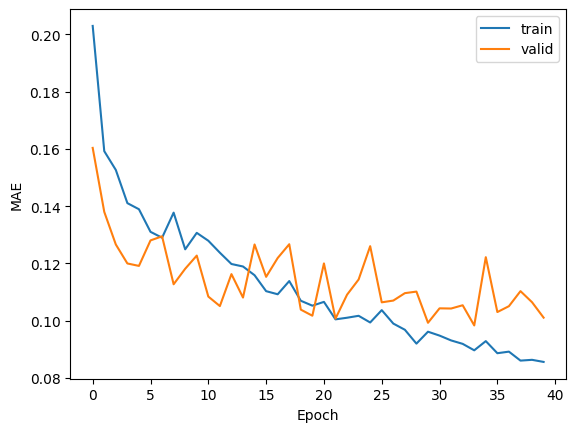

In [37]:
epochs = [x["epoch"] for x in history]
train_loss = [x["train_mae"] for x in history]
valid_loss = [x["valid_mae"] for x in history]

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label="train")
ax.plot(epochs, valid_loss, label="valid")
ax.set(xlabel="Epoch", ylabel="MAE")
plt.legend()

## Evaluating model accuracy on the test set

Now we can evaluate the model on the test set.

In [38]:
model.load_state_dict(torch.load('elastic-model.pt'))
test_loss, test_mae = evaluate(model, test_loader, criterion, device)
print(f"Test MAE: {test_mae:8.4f}")

Test MAE:   0.0981


<ipython-input-38-c33d2bdc6c8f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('elastic-model.pt'))


We can also plot the predictions of the model against the actual values.

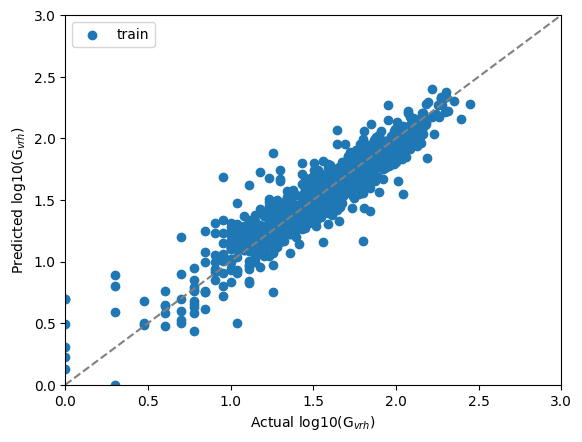

In [39]:
import matplotlib.pyplot as plt

actual = []
predicted = []

model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(device)
        y_pred = model(batch)
        predicted.extend(y_pred.data.cpu().tolist())
        actual.extend(batch.target.tolist())

fig, ax = plt.subplots()
ax.scatter(actual, predicted, label="train")
ax.plot([0, 3], [0, 3], ls="--", c="grey")
ax.set(ylabel="Predicted log10(G$_{vrh}$)", xlabel="Actual log10(G$_{vrh}$)", xlim=(0, 3), ylim=(0, 3))
plt.legend()

## Exercises

1. Assess the impact of changing the number of convolutions on the model accuracy. What is the optimum value for this dataset.
2. Try changing the node embedding length. Is the default value optimal.
3. How does the performance of our model compare to the state-of-the-art on the [matbench website](https://matbench.materialsproject.org)?
4. Advanced exercise: Currently our CGCNN model only has a single fully-connected before the final read-out step. The performance of the model could be improved by adding multiple dense layers before the read out. Try adding these extra layers with softplus activation and see how they impact the model performance.

   *Hint:* the dense layers should be added just before the `return self.fc_out(crys_feat)` line in the `CGCNN.forward` function.

## 1. Assess impact of convolutions

Create a function to initialise a model and get the final accuracy.


In [ ]:
def get_loss(num_convolutions=3, node_hidden_dim=64):
    """Train and evaluate a CGCNN model."""

    model = CGCNN(
        NUM_NODE_FEATURES,
        NUM_EDGE_FEATURES,
        num_graph_conv_layers=num_convolutions,
        node_hidden_dim=node_hidden_dim,
    )

    optimizer = torch.optim.AdamW(model.parameters())
    criterion = nn.MSELoss()

    model = model.to(device)
    criterion = criterion.to(device)

    best_valid_loss = float('inf')
    model_name = f"elastic-model-num-conv={num_convolutions}-node-hidden={node_hidden_dim}.pt"

    for epoch in range(EPOCHS):

        train_loss, train_mae = train(model, train_loader, criterion, optimizer, device)
        valid_loss, valid_mae = evaluate(model, valid_loader, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)

    model.load_state_dict(torch.load(model_name))
    test_loss, test_mae = evaluate(model, test_loader, criterion, device)
    return test_mae

Calculate the loss for 1, 2, 3, and 4 convolutional layers.

Plot the results.

## 2. Assess impact of embedding size

Calculate the loss for an embedding dimension of 16, 32, 64, 128, 256

Plot the results.

## 4. Adding additional fully-connected layers

Below we have copied the `CGCNN` class and added some additional hidden layers. We have added comments in the code where the additions were made.

In [ ]:
class CGCNN(nn.Module):
    def __init__(
        self,
        node_feat_dim,
        edge_feat_dim,
        node_hidden_dim=64,
        num_graph_conv_layers=3,
        num_fully_connected_layers=2,  # parameter to control the number of FC layers
        fc_feat_dim=128
    ):
        super().__init__()
        self.embedding = nn.Linear(node_feat_dim, node_hidden_dim)
        convs = []
        for _ in range(num_graph_conv_layers):
            convs.append(GraphConvolution(node_feat_dim=node_hidden_dim, edge_feat_dim=edge_feat_dim))
        self.convs = nn.ModuleList(convs)
        self.conv_to_fc = nn.Sequential(
           nn.Linear(node_hidden_dim, fc_feat_dim), nn.Softplus()
        )

        # Add the additional fully connected layers
        if num_fully_connected_layers > 0:
            fc_layers = []
            for _ in range(num_fully_connected_layers):
                fc_layers.append(nn.Linear(fc_feat_dim, fc_feat_dim))
                fc_layers.append(nn.Softplus())
            self.fc_layers = nn.Sequential(*fc_layers)
        else:
            self.fc_layers = None

        self.fc_out = nn.Linear(fc_feat_dim, 1)

    def forward(self, batch):
        """
        Predict the target property given a batch of data.

        Parameters
        ----------
        batch : Batch
            The data to pass through the network.
        """
        node_feat = self.embedding(batch.node_feat)
        for conv_func in self.convs:
            node_feat = conv_func(node_feat, batch.edge_feat, batch.edge_src, batch.edge_dst)
        crys_feat = torch_scatter.scatter_mean(node_feat, batch.batch, dim=0)
        crys_feat = self.conv_to_fc(crys_feat)

        # Run the crystal features through the fully connected layers
        if self.fc_layers:
            crys_feat = self.fc_layers(crys_feat)

        return self.fc_out(crys_feat)

Now create a function to calculate the loss with the different number of fully-connected layers.

In [ ]:
def get_loss(num_fully_connected_layers=1):
    """Train and evaluate a CGCNN model."""

    model = CGCNN(
        NUM_NODE_FEATURES,
        NUM_EDGE_FEATURES,
        num_fully_connected_layers=num_fully_connected_layers
    )

    optimizer = torch.optim.AdamW(model.parameters())
    criterion = nn.MSELoss()

    model = model.to(device)
    criterion = criterion.to(device)

    best_valid_loss = float('inf')
    model_name = f"elastic-model-num-fc={num_fully_connected_layers}.pt"

    for epoch in range(EPOCHS):

        train_loss, train_mae = train(model, train_loader, criterion, optimizer, device)
        valid_loss, valid_mae = evaluate(model, valid_loader, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)

    model.load_state_dict(torch.load(model_name))
    test_loss, test_mae = evaluate(model, test_loader, criterion, device)
    return test_mae

Calculate the loss for 0, 1, 2, 3, and 4 fully-connected layers.

Plot the results.